In [252]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [253]:
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms import smallworld
import random
from collections import Counter
from scipy.spatial import cKDTree

In [254]:
from src.neuron_population import NeuronPopulation
from src.connectome import Connectome
from src.overhead import Simulation
from src.neuron_templates import neuron_type_IZ
from src.network_grower import *
from src.network_generators import *
from src.neuron_type_distributor import *
from src.network_weight_distributor import *
from src.external_inputs import *

In [255]:
weight_scale = 1.0
g = 1.2984752590298583

J_I = weight_scale * g
J_E = weight_scale
delay_mean = 1.5
delay_std = delay_mean * 0.2
v_ext = 0.45527031369449

excitatory_type = "ss4"
inhibitory_type = "b"

In [256]:
seed = 1234

## Generate network

In [257]:
G = nx.DiGraph()

rng = np.random.default_rng(seed)

# Add 1000 nodes
for i in range(1000):
    G.add_node(i)

# Assign 800 nodes as excitatory and 200 as inhibitory
# excitatory_nodes = random.sample(range(1000), 800)
for i in range(800):
        G.nodes[i]['inhibitory'] = False
        G.nodes[i]['ntype'] = excitatory_type
        G.nodes[i]['layer'] = 0

for i in range(800, 1000):
        G.nodes[i]['inhibitory'] = True
        G.nodes[i]['ntype'] = inhibitory_type
        G.nodes[i]['layer'] = 0

# For each node, draw m outgoing edges to random nodes
n_out = 150
for i in range(1000):
    targets = rng.choice(range(1000), n_out, replace=False)
    for target in targets:
        if G.nodes[i]['inhibitory']:
            weight = J_I
            delay = max(0.1, rng.normal(1.5, 0.3))
        else:
            weight = J_E
            delay = max(0.1, rng.normal(delay_mean, delay_std))
        G.add_edge(i, target, weight=weight, distance=delay)

In [258]:
# Redistribute lognormally
G = assign_lognormal_weights_for_ntype(G, "ss4", mu=0.0, sigma=1.643570, w_max=100.0, rng=rng)

Text(0.5, 1.0, 'ss4 Weight Distribution after Lognormal Redistribution')

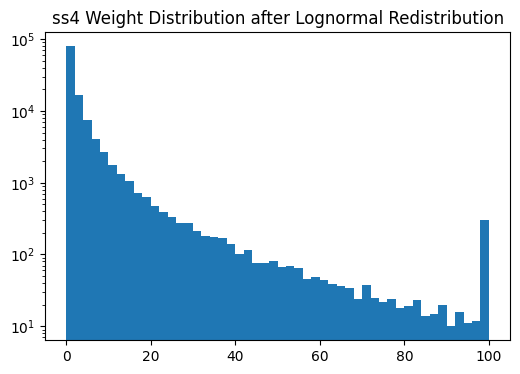

In [259]:
# Plot ss4 weight distribution
weights = [G[u][v]['weight'] for u, v in G.edges() if G.nodes[u]['ntype'] == 'ss4']
plt.figure(figsize=(6,4))
plt.hist(weights, bins=50, log=True)
plt.title("ss4 Weight Distribution after Lognormal Redistribution")

## Simulation setup

In [260]:
dt = 0.1

In [261]:
# Neuron population parameters
n_neurons = G.number_of_nodes()
neuron_types = [excitatory_type, inhibitory_type]
n_neuron_types = len(neuron_types)
inhibitory = [False, True]
threshold_decay = np.exp(-dt / 5)

pop = NeuronPopulation(n_neurons, neuron_types, inhibitory, threshold_decay)

In [262]:
# Connectome
# Max number of outgoing synapses per neuron
max_synapses = max(dict(G.out_degree()).values())

connectome = Connectome(max_synapses, pop)

connectome.nx_to_connectome(G)

In [263]:
nmda_weight = np.ones(connectome.neuron_population.n_neurons, dtype=float)
nmda_weight[pop.inhibitory_mask.astype(bool)] = 0.959685703507305
# Invert to make excitatory neurons have NMDA weight 1, inhibitory 0
# nmda_weight

## Simulation

100%|██████████| 30000/30000 [01:09<00:00, 429.43it/s]


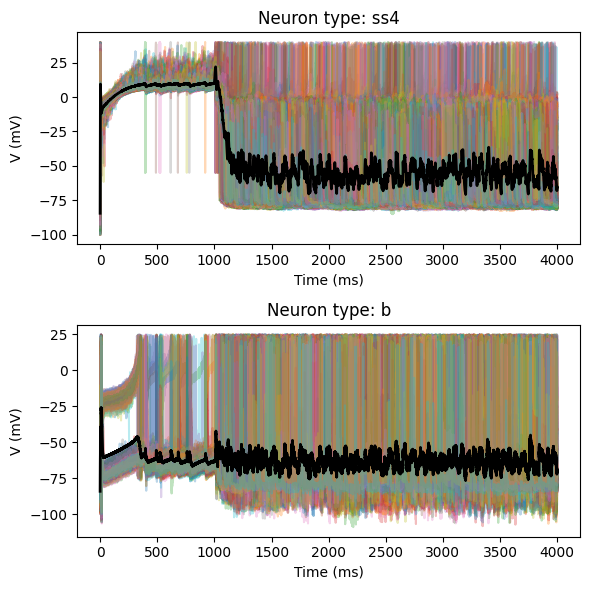

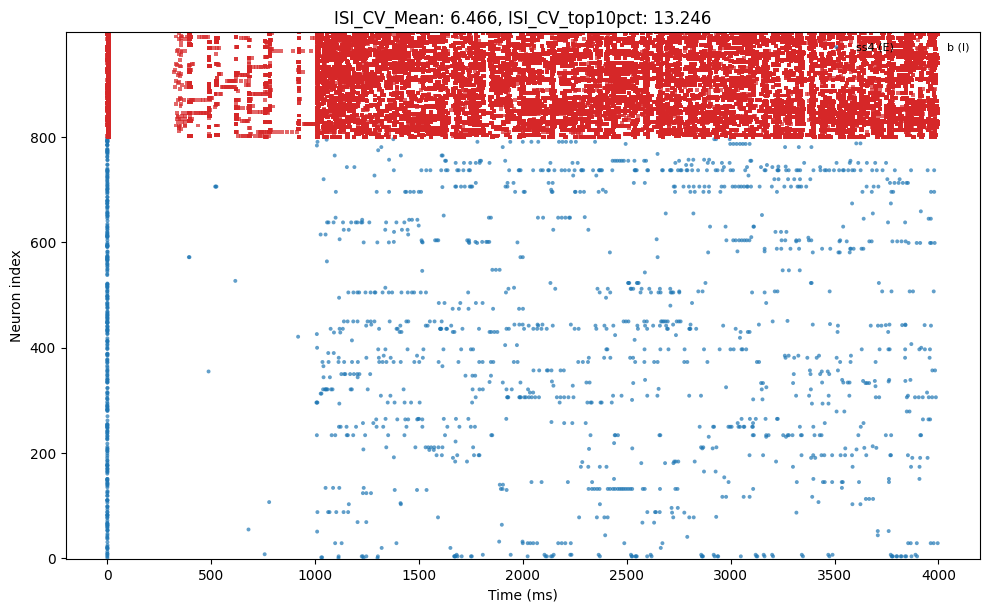

In [264]:

# Randomize initial voltages
Vs = rng.uniform(-100, -70, size=n_neurons)
us = rng.uniform(0, 400, size=n_neurons)
spikes = np.zeros(n_neurons, dtype=bool)
Ts = np.zeros_like(spikes)

state0 = (Vs,
          us,
          spikes.copy(),
          Ts.copy())

# sim = Simulation(connectome, dt, stepper_type="simple", state0=state0,
#                  enable_plasticity=False)
sim = Simulation(connectome, dt, stepper_type="euler_det", state0=state0,
                 enable_plasticity=False, synapse_kwargs={"LT_scale": 1.0, "NMDA_weight": nmda_weight}, synapse_type="standard",
                 enable_debug_logger=True)

# rate = np.zeros(n_neurons)
poisson = PoissonInput(n_neurons, rate=v_ext, amplitude=2.44625509556019)

from tqdm import tqdm

for i in tqdm(range(10000)):
    sensory_spikes = poisson(dt)
    sensory_spikes[pop.inhibitory_mask.astype(bool)] = False
    sim.step(spike_ext=sensory_spikes)
    # sim.step()

for i in tqdm(range(30000)):
    sim.step()

sim.plot_voltage_per_type(figsize=(6, 6))

stats = sim.stats.compute_metrics(dt, bin_ms_participation=300)

isi_mean = stats['ISI_CV_mean']
isi_top = stats["ISI_CV_mean_top10pct"]

sim.plot_spike_raster(figsize=(10, 6), title=f"ISI_CV_Mean: {isi_mean:.3f}, ISI_CV_top10pct: {isi_top:.3f}", t_start_ms=0.0, t_stop_ms=9000.0)

In [269]:
sim.stats.compute_metrics(dt, bin_ms_participation=300, t_start_ms=1000.0, t_stop_ms=4000.0)

{'rate_mean_Hz': 66.29679010699643,
 'rate_median_Hz': 0.0,
 'rate_p95_Hz': 450.2516582780571,
 'ISI_CV_median': 6.9479255403891695,
 'ISI_CV_mean': 5.984803303330798,
 'ISI_CV_mean_E': 1.4141642661647864,
 'ISI_CV_mean_I': 8.178710041170483,
 'ISI_CV_mean_top10pct': 11.609073886090433,
 'refractory_violations_per_neuron': 189.853,
 'Fano_median_2ms': 12.590458802108191,
 'Fano_median_10ms': 20.73219675340563,
 'Fano_median_50ms': 24.42189647274394,
 'Fano_median_100ms': 28.92228512609367,
 'Fano_median_300ms': 29.815073815073816,
 'Fano_median_500ms': 28.3551867219917,
 'Fano_median_1000ms': 14.877318116975749,
 'mean_noise_corr_2ms': 0.0011585769547191895,
 'mean_noise_corr_10ms': 0.0016711392559874258,
 'mean_noise_corr_50ms': 0.0006571117370437893,
 'mean_noise_corr_100ms': 0.00047794748240123907,
 'mean_noise_corr_300ms': 0.0004253452943646638,
 'mean_noise_corr_500ms': 0.0003869766794489571,
 'mean_noise_corr_1000ms': -0.00015680899433397844,
 'participation_frac_mean_300ms': 0.2

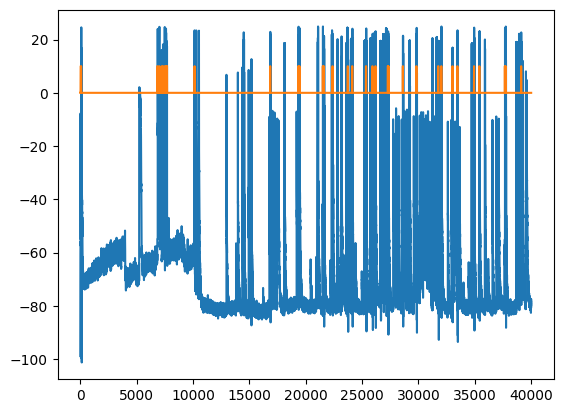

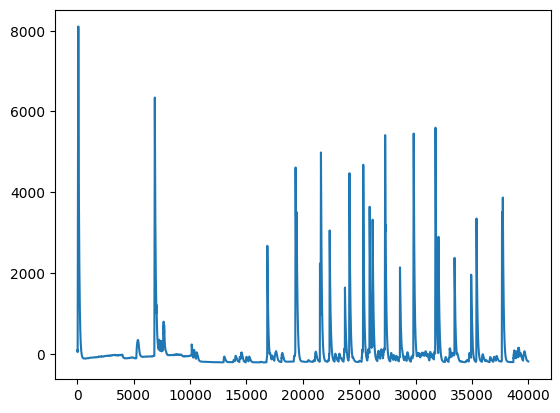

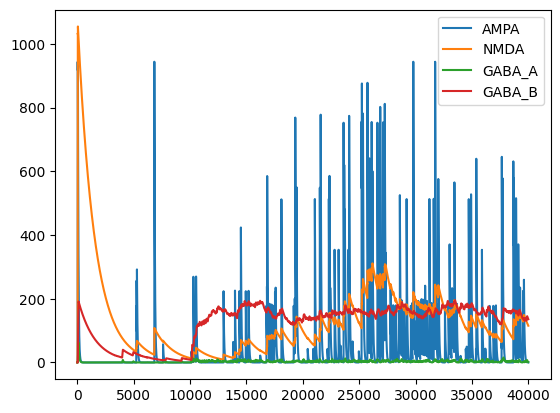

In [279]:
# Plot spikes for one neuron
n_idx = 847
t_first = 0
t_last = -1
plt.plot(np.array(sim.stats.Vs)[t_first:t_last,n_idx])
plt.plot(np.array(sim.stats.spikes)[t_first:t_last,n_idx] * 10)
plt.show()
plt.plot(np.array(sim.stats.us)[t_first:t_last,n_idx])
plt.show()
plt.plot(np.array(sim.debug_logger.s_ampa)[t_first:t_last,n_idx], label="AMPA")
plt.plot(np.array(sim.debug_logger.s_nmda)[t_first:t_last,n_idx], label="NMDA")
plt.plot(np.array(sim.debug_logger.s_gaba_a)[t_first:t_last,n_idx], label="GABA_A")
plt.plot(np.array(sim.debug_logger.s_gaba_b)[t_first:t_last,n_idx], label="GABA_B")
plt.legend()
plt.show()

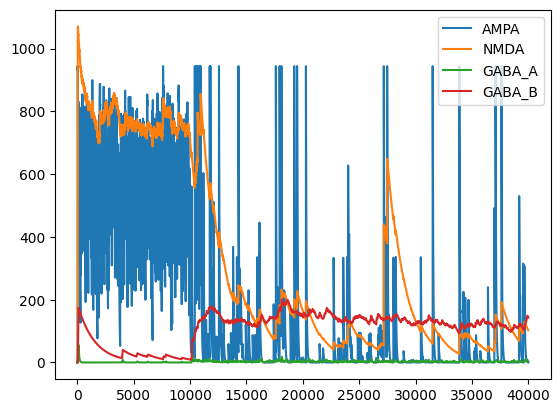

In [267]:
plt.plot(np.array(sim.debug_logger.s_ampa)[t_first:t_last,n_idx], label="AMPA")
plt.plot(np.array(sim.debug_logger.s_nmda)[t_first:t_last,n_idx], label="NMDA")
plt.plot(np.array(sim.debug_logger.s_gaba_a)[t_first:t_last,n_idx], label="GABA_A")
plt.plot(np.array(sim.debug_logger.s_gaba_b)[t_first:t_last,n_idx], label="GABA_B")
plt.legend()
plt.show()

In [268]:
# connectome.compute_metrics(small_world=False)